### Downloading data from kaggle (kaggle api)

For this to work you need to:
- have kaggle account,
- create kaggle api token and put it in a right folder on your computer (credentials),
- enter competition and accept its rules.

[Kaggle API](https://www.kaggle.com/docs/api)

In [1]:
#!kaggle competitions list

In [2]:
#!kaggle competitions download -c house-prices-advanced-regression-techniques

### Importing and loading data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from pyod.models.knn import KNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import KFold, train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from math import sqrt
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%matplotlib inline
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Dependent variable

In [5]:
df_train['SalePrice'].corr(df_train['Id'])

-0.02191671944343111

Removing id variables (after checking there is no correlation)

In [6]:
test_id = df_test['Id']

In [7]:
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

In [8]:
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

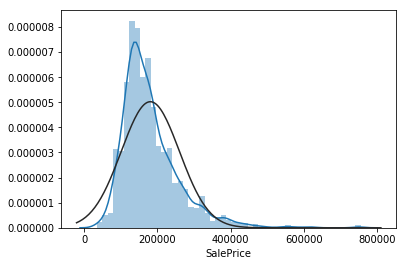

In [9]:
sns.distplot(df_train['SalePrice'], fit=norm)

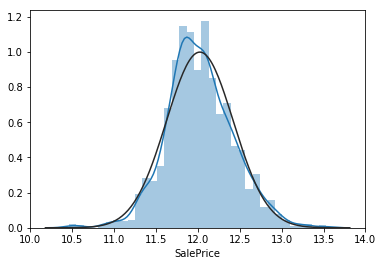

In [10]:
sns.distplot(np.log1p(df_train['SalePrice']), fit=norm)

Sale Prices have right skewed distribution, while for logarithms it seems quite normal. Since evaluation will be based on logarithm of sale prices, we should transform it.

In [11]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

### Missing data

In [12]:
missing_data = df_train.isnull().sum().sort_values(ascending=False)
columns = pd.DataFrame({'Missing data [%]': missing_data[missing_data>0]/df_train.shape[0]})
columns

,Missing data [%]
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageType,0.055479
GarageCond,0.055479
GarageFinish,0.055479
GarageQual,0.055479


Basically only a small amount of houses have features like:
- swimming pool,
- miscellaneous (other),
- alley access to property,
- fence,
- fireplace. <br><br>
I'm going to make binary variables of out them, since not only not many houses have these features, but also they have few classes on their own. Even though there is 99,5% houses have swimming pools, i think that variable may differentiate price.

In [13]:
binary = missing_data.index.tolist()[:5]

In [14]:
for feature in binary:
    name = '{}_bool'.format(feature)
    df_train[name] = np.where(df_train[feature].isna()==True, 'None', 'Has')
    df_test[name] = np.where(df_test[feature].isna()==True, 'None', 'Has')

In [15]:
df_train.drop(binary, axis=1, inplace=True)
df_test.drop(binary, axis=1, inplace=True)

Filling rest of missing data with mean/median (numeric/categorical).

In [16]:
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [17]:
df_train.fillna('Missing', inplace=True)
df_test.fillna('Missing', inplace=True)

### Skewness

Checking the distribution of left variables, mainly skewness.

In [18]:
skewed_variables = df_train.skew(numeric_only=True).abs().sort_values(ascending=False)
columns_2 = pd.DataFrame({'Skewness': skewed_variables[skewed_variables>3.0]})
columns_2

,Skewness
MiscVal,24.476794
PoolArea,14.828374
LotArea,12.207688
3SsnPorch,10.304342
LowQualFinSF,9.011341
KitchenAbvGr,4.488397
BsmtFinSF2,4.255261
ScreenPorch,4.122214
BsmtHalfBath,4.103403
EnclosedPorch,3.089872


In [19]:
df_train[columns_2.index] = np.log1p(df_train[columns_2.index])
df_test[columns_2.index] = np.log1p(df_test[columns_2.index])

#### Categorical data

I want to check categorical variables now. If variable has too many classes, it can be problematic for model to learn the dependency.

In [20]:
df_train.select_dtypes(include='object').nunique().sort_values(ascending=False)[:5]

Neighborhood    25
Exterior2nd     16
Exterior1st     15
Condition1       9
SaleType         9
dtype: int64

In [21]:
df_train['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

There is nothing we can do about without using external data. Seems ok :-)

### Differences between test and training sets

In [22]:
((df_train.mean()-df_test.mean())/df_train.mean()).abs().sort_values(ascending=False)[:10]

LowQualFinSF     0.455274
3SsnPorch        0.454911
PoolArea         0.201856
ScreenPorch      0.197512
EnclosedPorch    0.170302
BsmtHalfBath     0.135228
BsmtFinSF2       0.082237
2ndFlrSF         0.060591
Fireplaces       0.051865
OpenPorchSF      0.035440
dtype: float64

In [23]:
df_train['LowQualFinSF'].describe(), df_test['LowQualFinSF'].describe()

(count    1460.000000
 mean        0.099814
 std         0.747354
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         6.350886
 Name: LowQualFinSF, dtype: float64, count    1459.000000
 mean        0.054371
 std         0.557179
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         6.970730
 Name: LowQualFinSF, dtype: float64)

Dataset is pretty well balanced.

### Outliers

In [24]:
df_outliers = df_train.select_dtypes(include='number')

2,5% - arbitrary number

In [25]:
clf = KNN(contamination=0.025)

In [26]:
clf.fit(X=df_outliers.values)

KNN(algorithm='auto', contamination=0.025, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [27]:
scores_pred = clf.decision_function(df_outliers.values)*-1

In [28]:
outliers_pred = clf.predict(df_outliers.values)
outliers = pd.DataFrame(outliers_pred, columns=['outlier'])
outliers.shape, sum(outliers_pred), df_outliers.shape

((1460, 1), 30, (1460, 37))

In [29]:
df_train_clean = pd.concat([df_train, outliers], axis=1)

In [30]:
df_train_clean.query('outlier==0', inplace=True)
df_train_clean.drop('outlier', axis=1, inplace=True)

### Preparing dataset for models

In [31]:
def add_dummies(train, test, y_name):
    """
    train: DataFrame with training data
    test: DataFrame with test data
    y_name: string containing name of dependent variable
    """
    y = train[y_name]
    all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
    categorical = pd.get_dummies(all_data.select_dtypes(include='object'))
    numerical = all_data.drop(y_name, axis=1).select_dtypes(include='number')
    new_training = pd.concat([numerical, categorical], axis=1)[:len(train)]
    new_test = pd.concat([numerical, categorical], axis=1)[len(train):]
    return new_training, new_test, y

In [32]:
def my_rmse(actual, predictions):
    return sqrt(mean_squared_error(actual, predictions))

In [33]:
def cv_results(model, train, kfold=5):
    training_results = []
    val_results = []
    cv = KFold(n_splits=kfold, shuffle=True, random_state=123)
    for train, val in cv.split(train):
        model.fit(x.values[train], y.values[train])
        training_results.append(my_rmse(y.values[train], model.predict(x.values[train])))
        val_results.append(my_rmse(y.values[val], model.predict(x.values[val])))
    print('Validation result - RMSE:', np.mean(val_results))
    print('Training result - RMSE:', np.mean(training_results))

In [34]:
cv_5 = KFold(n_splits=5, shuffle=True, random_state=123)

In [35]:
def cv_rmse(model, training, labels):
    rmse = np.sqrt(-cross_val_score(model, training, labels,
                                    scoring="neg_mean_squared_error",
                                    cv=cv_5))
    return (rmse)

### Models

In [36]:
rf_reg = RandomForestRegressor(max_depth=4, random_state=123, n_estimators=250, max_features='auto')

In [37]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate=0.05, subsample=0.8, 
                          max_depth=4, alpha=10, n_estimators=250, num_boost_round=50, gamma=0.05,
                         reg_alpha=0.5, reg_lambda=0.9, early_stopping_rounds=20, seed=123)

In [38]:
lgb_reg = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=250)

In [39]:
lasso_reg = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=123))

In [40]:
enet_reg = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=123))

In [41]:
ridge_reg = make_pipeline(RobustScaler(), Ridge(alpha=0.0005, random_state=123))

In [42]:
models = {'Random forest':rf_reg, 'xgboost':xg_reg, 'LightGBM':lgb_reg, 'Lasso':lasso_reg,
         'ElasticNet':enet_reg, 'Ridge':ridge_reg}

In [43]:
x, test_x, y = add_dummies(df_train, df_test, 'SalePrice')

In [44]:
for k,v in models.items():
    result = cv_rmse(v, x, y)
    print("{}: {:.4f}, {:.4f}".format(k, result.mean(), result.std()))

Random forest: 0.17602, 0.00853
xgboost: 0.12799, 0.00972
LightGBM: 0.12943, 0.00992
Lasso: 0.13543, 0.02919
ElasticNet: 0.13553, 0.02901
Ridge: 0.15064, 0.02834


In [45]:
x_clean, test_x_clean, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [46]:
for k,v in models.items():
    result = cv_rmse(v, x_clean, y)
    print("{}: {:.5f}, {:.5f}".format(k, result.mean(), result.std()))

Random forest: 0.16820, 0.00981
xgboost: 0.12150, 0.00723
LightGBM: 0.12129, 0.00604
Lasso: 0.11016, 0.00686
ElasticNet: 0.11014, 0.00677
Ridge: 0.12323, 0.00545


Each algorithm has better results when data is clean.

### Grid/Randomized Search

In [47]:
rf = RandomForestRegressor()
grid = {'n_estimators': [100, 200, 500, 1000],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [None, 3, 5, 10, 15],
        'min_samples_split': [2, 10, 20, 50]}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=grid, n_iter=100,
                               cv=3, random_state=123, n_jobs=-1, scoring='neg_mean_squared_error')
rf_random.fit(x_clean, y)
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'max_features': 'auto',
 'max_depth': 15}

In [88]:
xgboost = xgb.XGBRegressor(objective='reg:linear', early_stopping_rounds=20, num_boost_round=100)
grid = {'learning_rate': [0.01, 0.05, 0.10, 0.15, 0.3],
        'max_depth': [3, 5, 10, 15],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.2, 0.3, 0.4, 0.6, 0.8, 1],
        'n_estimators': [100, 200, 500, 1000]}
xgb_random = RandomizedSearchCV(estimator=xgboost, param_distributions=grid, n_iter=100,
                               cv=3, random_state=123, n_jobs=-1, scoring='neg_mean_squared_error')

xgb_random.fit(x_clean, y)
xgb_random.best_params_

{'subsample': 0.8,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.05,
 'colsample_bytree': 0.3}

In [89]:
lightgbm = lgb.LGBMRegressor(objective='regression')
grid = {'learning_rate': [0.01, 0.05, 0.10, 0.15],
        'max_depth': [-1, 3, 5, 10, 15],
        'feature_fraction': [0.6, 0.8, 1],
        'n_estimators': [100, 200, 500, 1000]}
lgb_random = RandomizedSearchCV(estimator=lightgbm, param_distributions=grid, n_iter=100,
                               cv=3, random_state=123, n_jobs=-1, scoring='neg_mean_squared_error')
lgb_random.fit(x_clean, y)
lgb_random.best_params_

{'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.05,
 'feature_fraction': 0.6}

In [90]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state=123))
grid = {'lasso__alpha': [1e-15, 1e-10, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]}
lasso_grid = GridSearchCV(estimator=lasso, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=1, refit=True, cv=5)
lasso_grid.fit(x_clean, y)
lasso_grid.best_params_

{'lasso__alpha': 0.001}

In [91]:
ridge = make_pipeline(RobustScaler(), Ridge(random_state=123))
grid = {'ridge__alpha': [1e-15, 1e-10, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20]}
ridge_grid = GridSearchCV(estimator=ridge, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=1, refit=True, cv=5)
ridge_grid.fit(x_clean, y)
ridge_grid.best_params_

{'ridge__alpha': 10}

In [92]:
elastic = make_pipeline(RobustScaler(), ElasticNet())
grid = {'elasticnet__alpha': [1e-15, 1e-10, 1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20],
        'elasticnet__l1_ratio':[0.2, 0.4, 0.6, 0.8]}
elastic_grid = GridSearchCV(estimator=elastic, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=1, refit=True, cv=5)
elastic_grid.fit(x_clean, y)
elastic_grid.best_params_

{'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.6}

### Models with optimized parameters

In [48]:
rf_reg = RandomForestRegressor(max_depth=15, random_state=123, n_estimators=200, max_features='auto', min_samples_split=2)

In [49]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', subsample=0.8, n_estimators=500, max_depth=3, learning_rate=0.05,
                          colsample_bytree=0.3)#, num_boost_round=50, gamma=0.05, 
                          #reg_alpha=0.5, reg_lambda=0.9, early_stopping_rounds=20, seed=123)

In [50]:
lgb_reg = lgb.LGBMRegressor(objective='regression', max_depth=3, feature_fraction=0.6, learning_rate=0.05, n_estimators=500)

In [51]:
lasso_reg = make_pipeline(RobustScaler(), Lasso(alpha=0.001, random_state=123))

In [52]:
ridge_reg = make_pipeline(RobustScaler(), Ridge(alpha=10, random_state=123))

In [53]:
enet_reg = make_pipeline(RobustScaler(), ElasticNet(alpha=0.001, l1_ratio=.6, random_state=123))

In [55]:
models = {'Random forest':rf_reg, 'xgboost':xg_reg, 'LightGBM':lgb_reg, 'Lasso':lasso_reg,
         'ElasticNet':enet_reg, 'Ridge':ridge_reg}

In [56]:
x_clean, test_x_clean, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [57]:
for k,v in models.items():
    result = cv_rmse(v, x_clean, y)
    print("{}: {:.5f}, {:.5f}".format(k, result.mean(), result.std()))

Random forest: 0.13706, 0.00857
xgboost: 0.11296, 0.00670
LightGBM: 0.11969, 0.00547
Lasso: 0.11143, 0.00689
ElasticNet: 0.11036, 0.00684
Ridge: 0.11168, 0.00609


Random forest clearly has worst results.

## Averaging models

In [58]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [59]:
models = [xg_reg, lgb_reg, lasso_reg, enet_reg, ridge_reg]
results = np.zeros(len(test_x))

In [60]:
for model in models:
    model.fit(x.values, y.values)
    results = results + model.predict(test_x.values)

### Kaggle submission

In [61]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = np.exp(results/len(models))
#sub.to_csv('submission.csv', index=False)

In [62]:
#!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Ensemble models"

Top 15%, <br>
Your submission scored 0.11652

### TODO: Stacking using mlxtend, better tensorflow

## Learning TensorFlow 2.0

[Tutorial](https://www.tensorflow.org/tutorials/keras/basic_regression)

Normalizing data

In [72]:
x, test_x, y = add_dummies(df_train_clean, df_test, 'SalePrice')

In [73]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
test_x = scaler.transform(test_x)

Just a random split, not cv, because of time.

In [74]:
train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.25, random_state=123)

In [75]:
list(map(len, [train_data, test_data, train_labels, test_labels]))

[1072, 358, 1072, 358]

In [76]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[train_data.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

In [77]:
tf_model = build_model()

In [78]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

In [79]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                9536      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [81]:
EPOCHS = 1000

In [82]:
history = tf_model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), early_stop])


....................................................................................................
....................

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
115,0.067855,0.067855,2.182414,2.182414,115
116,0.050478,0.050478,2.304442,2.304442,116
117,0.055651,0.055651,2.365863,2.365863,117
118,0.050402,0.050402,2.541471,2.541470,118
119,0.065181,0.065181,2.243968,2.243968,119


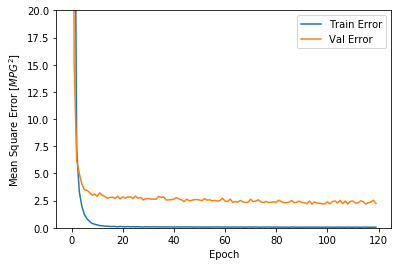

In [84]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [85]:
print(np.sqrt(tf_model.evaluate(test_data, test_labels, verbose=0))[0])

1.2691201826217178
